In [2]:
import time
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt
from itertools import cycle, combinations
from sklearn import preprocessing

In [3]:
# Import data
data = pd.read_csv("sc2_prediction_data2021-07-31.csv")
predictors = ['scout_freq', 'scout_freq_fb',
             'scout_mb', 'scout_first']
pairs_indices = list(combinations(range(len(predictors)), 2))
# data

In [32]:
# Clean and wrangle data
skill_lookup = {
    1: "Novice",
    2: "Novice",
    3: None,
    4: "Proficient",
    5: "Proficient",
    6: None,
    7: "Expert"
}
data = data.dropna()
# mutate a new variable "Skill" to map ranks to skill levels
data["Skill"] = data.apply(lambda r: skill_lookup[r['rank']], axis = 1)
# sample an equal number of players in each skill level
data = data.groupby('Skill', as_index = False).apply(lambda r: r.sample(n = 1000))

In [20]:
# Standardization function
def standardize(X):
#     scaler = preprocessing.StandardScaler().fit(X)
    min_max_scaler = preprocessing.MinMaxScaler()
    X_scaled = min_max_scaler.fit_transform(X)
    return X_scaled
# Plot 2D clusters function 
def plotClusters(labels, model, X, x_1, x_2, predictors_names):
    print(predictors_names[x_1], '~', predictors_names[x_2], '\n')
    plt.figure(1)
    plt.clf()
    cluster_centers = model.cluster_centers_
    n_clusters_ = len(np.unique(labels))
    colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    for k, col in zip(range(n_clusters_), colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
        my_members = labels == k
        cluster_center = cluster_centers[k]
        plt.plot(X[my_members, x_1], X[my_members, x_2], col + '.', alpha = 0.2)
        plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=14)
    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    
# Clustering function
def clustering(model, df, predictors):  
    X = df[predictors].values
    X = standardize(X)
    y_labels = model.fit_predict(X)
    score = metrics.silhouette_score(X, y_labels, metric='euclidean')
    print(type(model), '\n')
    print("Silhouette score:", score, '\n')
    return model, y_labels, X

In [50]:
# K-means
km = KMeans(n_clusters=3, init='random',
            n_init=10, max_iter=300, 
            tol=1e-04, random_state=0)
model, y_labels, X = clustering(km, data, predictors)

<class 'sklearn.cluster.k_means_.KMeans'> 

Silhouette score: 0.41218547661584154 



scout_freq ~ scout_freq_fb 



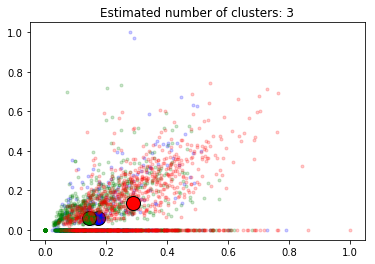

scout_freq ~ scout_mb 



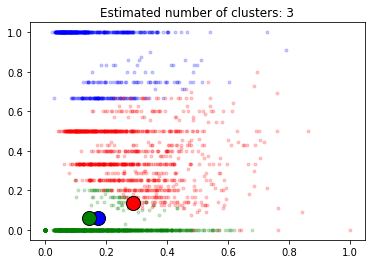

scout_freq ~ scout_first 



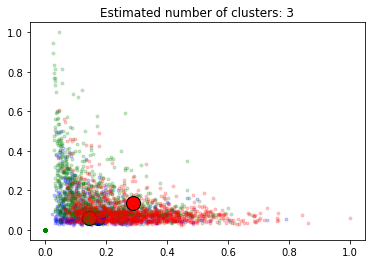

scout_freq_fb ~ scout_mb 



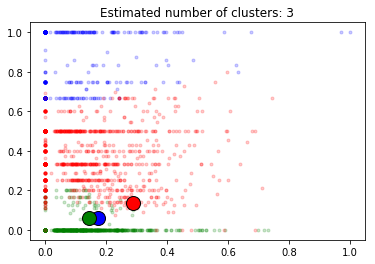

scout_freq_fb ~ scout_first 



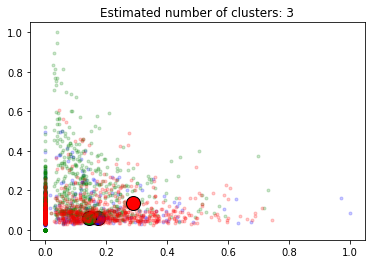

scout_mb ~ scout_first 



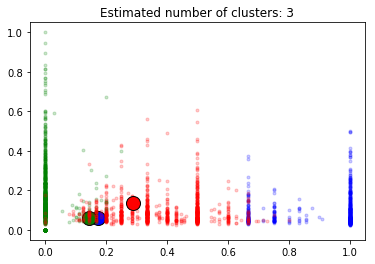

In [51]:
# print(X)
for pair_index in pairs_indices:  
    plotClusters(y_labels, model, X, pair_index[0], pair_index[1], predictors)

In [33]:
# Compute DBSCAN
X = data[predictors].values
X = standardize(X)
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))


Estimated number of clusters: 1
Estimated number of noise points: 2
Silhouette Coefficient: 0.545


scout_freq ~ scout_freq_fb 



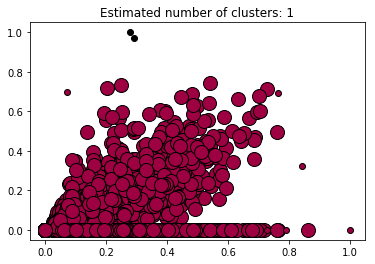

scout_freq ~ scout_mb 



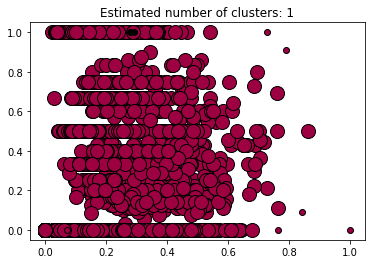

scout_freq ~ scout_first 



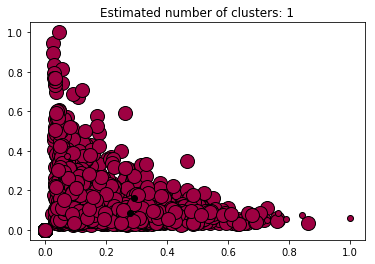

scout_freq_fb ~ scout_mb 



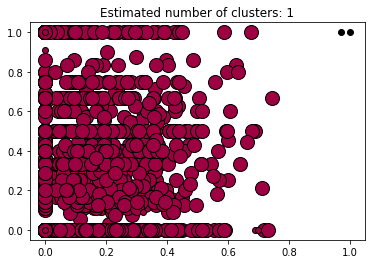

scout_freq_fb ~ scout_first 



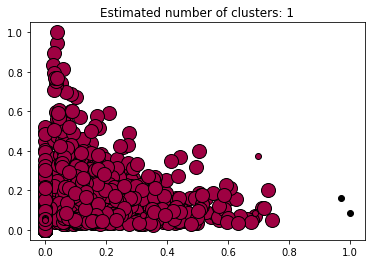

scout_mb ~ scout_first 



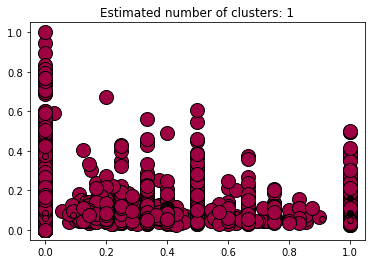

In [47]:
# #############################################################################
for pair_index in pairs_indices: 
    print(predictors[pair_index[0]], '~', predictors[pair_index[1]], '\n')
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, pair_index[0]], xy[:, pair_index[1]], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, pair_index[0]], xy[:, pair_index[1]], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()

In [48]:
# Mean shift
X = data[predictors].values
X = standardize(X)
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
clustering(ms, data, predictors)

<class 'sklearn.cluster.mean_shift_.MeanShift'> 

Silhouette score: 0.40549793148683877 



(MeanShift(bandwidth=0.2997911637597357, bin_seeding=True, cluster_all=True,
      min_bin_freq=1, n_jobs=None, seeds=None),
 array([2, 1, 1, ..., 2, 1, 0]),
 array([[0.30050761, 0.28313484, 0.75      , 0.06349081],
        [0.28553055, 0.17635798, 0.5       , 0.05290462],
        [0.38111588, 0.25978146, 0.375     , 0.12719229],
        ...,
        [0.10230415, 0.        , 1.        , 0.21354084],
        [0.51034483, 0.3918389 , 0.14285714, 0.07352399],
        [0.15744681, 0.13505589, 0.        , 0.166614  ]]))

In [49]:
X = np.array([[ 10., -1.,  4],
    [ 12,  0.,  5],
    [ 15,  1., 4.4]])
X = standardize(X)
X

array([[0. , 0. , 0. ],
       [0.4, 0.5, 1. ],
       [1. , 1. , 0.4]])